__Author:__ John Leraas

__Date:__ 2/8/2022

__Purpose:__ This notebook was created to explain and commpare different A/B testing methods, highlight nuances, and provide resources for further reference.

# A/B Testing

A/B testing is commonly applied to website optimization, where many observations can be obtained over a short period of time at a low cost to the organization. Specific web-oriented A/B tests cover areas such as e-commerce, media, and really any aspect of any website (web optimization more generally). However, it is more generally applied to any service with measured user behavior, in making many broader business decisions, and in clinical trials.

There are two frequently used approaches to A/B testing: the Frequentist Approach and the Bayesian Approach. In this example we will look at a 'fixed size' experiments and compare the analyses, though the Frequentist Approach can be modified for Sequential A/B Testing.

### Frequentist Approach
The Frequentist Approach to A/B testing utilizes simple hypothesis testing to compare the observed data distributions of A and B. Specifically, and perhaps counterintuitively, this involves selecting an outcome you wish to test (B is better or worse than A), selecting a null hypothesis that is essentially the opposite (B is the same as A), and tryinig to disprove the null hypothesis (more specifically, that the probability of observing the data is extremely small if the null hypothesis is true). The general procedure for a Frequentist A/B test is as follows (with additional detail presented subsequently):
* __State the Null Hypothesis:__ e.g. There is no difference between A and B
* __Select Acceptable Uncertainty in Results:__ This corresponds to both an acceptable false positive rate and false negative rate. The false positive rate corresponds to a "Significance Level". The most common "rule of thumb" value is a 95% significance level (corresponding to a 5% false positive rate), but this should be selected based upon the problem (and cost associated with a false positive). The false negative rate corresponds to the "Statistical Power" of the experiment. A typical rule of thumb value is 80%, corresponding to a 20% false negative rate.
* __Select Size of Experiment:__ This must be performed __PRIOR__ to the start of the experiment. p-values fluctuate over the course of the experimental trials, and so failing to adhere to this predefined experimental parameter can result in an undo number of false positives (with the tendancy to stop experiments once the p-value reaches the signficance level). Note that Sequential A/B Testing can be applied as an alternative to this fixed size approach. Generally the sequential approach outperforms when the difference in rates between A and B are large, but can result in longer experiments when the difference is small.
* __Collect all Observations:__ Run the experiment
* __Check for Significance:__ Compare the two distributions using a paired t-test
* __Accept or Reject Null Hypothesis__


### Bayesian Approach
* __Select a Likelihood Function:__ For binary outcomes (e.g. click or don't click), and specifically Bernoulli Random Trials, a Binomial Distribution is appropriate.
* __Select a Prior Function:__ The specific A/B testing problem makes the Beta Distribution a particularly good choice.
* __Apply Belief in Model Parameters Through Prior:__ If there is a strong (or weak) belief derived from pre-existing knowledge or insight, this can be incorporated in the prior. Additionally, a uniform prior can be used to convey no pre-existing insight or expectation regarding the prior.
* __Collect All Observations:__ Run the experiment
* __Calculate Posterior Probobalities:__ Calculate the probability distribution of the parameter, representing the conversion rate in this case, of both A and B.
* __Compare Results:__ Calculate the probability that B is better than A. Interestingly, the conversion rate of A and B are represented by distributions so this is solved via an integration of the probability distributions.

## Experimental Design

Before any code or modeling is implemented, there are some important considerations regarding experimental design and actual implementation. While not an exhaustive list (as there are books written on the subject), some key considerations are:

* __Measurement of Metric:__ Choice of how you measure the metric of interest will affect the experimental requirements and outcomes. For example, if we are interested in purchases of a user we could measure (i) whether a purchase occurs (e.g. 0/1), (ii) how many items are purchased (e.g. 0, 1, 2, ...), or (iii) revenue (e.g. \\$0, \\$23.37, \\$102.67). The binary measurement results in the lowest variance and requires the smallest number of observations to be obtained.
* __Outliers:__ Outliers can effect the variance and thus affect the statistical signficance of the experiment. Caps can be placed on the measurement to reduce the effect of outliers (e.g. revenue up to max of \\$250).
* __Time and Timeframe:__ This will depend heavily upon the amount of data received and the effect of time on the measured metrics. For example, if tens of thousands of page visits are expected over a few hours, this may be a great choice for the duration of the experiment. If the website is expected to receive statistically significant numbers of views over a multi-day period it may be advantageous to run the experiment over a two-week interval in order to be able to normalize (or at least compare) the potential effects that day of week may introduce. In the context of some problems models corresponding to different days of week or time of day may be desireable. Depending upon the experiment seasonality may also require consideration.
* __Randomization Unit__: For web-oriented experiments this is often the user. It should be noted that adding number of users over the course of the experiment will not be linear with time due to traffic generated from return users. Additionally, if the randomization unit (e.g. user) is different from the metric being observed (e.g. page-view) this can create issues with estimating variance.
* __Novelty/Primacy Effects:__ The introduction of any new feature may result in a short term increase (novelty) or decrease (primacy) in traffic. This can be monitored by tracking conversion metrics over a longer period of time (dependent on context of the problem).
* __Bots:__ Bots filtering can pose a serious problem. It has been noted that over 50% of Bing's US traffic and over 90% of Bing's China and Russia traffic comes from bots ("Trustworth Online Controlled Experiments A Practical Guide to A/B Testing" p. 48).
* __A/A Testing:__ This should be implemented before running experiments and on a regular basis in order to ensure that the experiment is running as expected.


# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import math
from scipy import stats
from scipy.special import betaln
import matplotlib.pyplot as plt

# Data Setup

Prior to exploring both statistical approaches in greater detail, let's define a common set of data from which we can illustrate both approaches and compare them. For the sake of this problem we wil look at binomial outcomes (e.g. someone clicks or they don't, someone gets better in a clinical trial or they don't, ...). In more general non-binary problems, it can often advantageous to define the problem in a binomial fashion in order to reduce variance. For example, creating a binary observation for whether someone purchased an item from a website (1 if revenue > 0) may be advantageous relative to using revenue. 

An arbitrary dataset is generated below:

In [2]:
mean_A = .25  #True Mean of A
mean_B = .3  #True Mean of B
n = 100000  #Arbitrarily large number of observations
sample = int(n/2) #Number of observations from A and B separately

# Create Datasets - Binomial Distribution
X1=np.random.binomial(n=1, p=mean_A, size=sample)
X2=np.random.binomial(n=1, p=mean_B, size=sample)

In [3]:
# Display Dataset Descriptive Statistics
pd.DataFrame({"X1": X1,
            "X2": X2}).describe().round(3)

,X1,X2
count,50000.000,50000.000
mean,0.250,0.298
std,0.433,0.458
min,0.000,0.000
25%,0.000,0.000
50%,0.000,0.000
75%,0.000,1.000
max,1.000,1.000


### Display Data

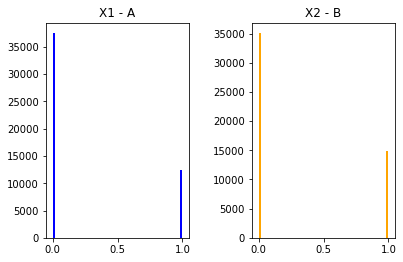

In [4]:
fig, (ax1, ax2) = plt.subplots(1,2)

ax1.hist(X1, bins=50, color='blue')
ax1.set_title("X1 - A")

ax2.hist(X2, bins=50, color='orange')
ax2.set_title("X2 - B")

fig.tight_layout(pad=2)

plt.show()

# Frequentist Approach

## Null Hypothesis

__Null Hypothesis:__ The average conversion rate of A is equal to the average conversion rate of B.
$$
H_0: \mu_A = \mu_B
$$

__Alternative Hypothesis:__ The average conversion rate of A is not equal to the average conversion rate of B.
$$
H_A: \mu_A \neq \mu_B
$$

or (in the case of the proceding experiment), we can select the average conversion rate of B to be greater than the average conversion rate of A
$$
H_A: \mu_A <= \mu_B
$$

## Select Acceptable Uncertainty in Results:
__Significance Level:__ For the purpose of this example, we will choose $\alpha = 0.05$ (corresponding to a 5% false positive rate), as this is a common rule of thumb statistical. To be emphasized, this means that we expect approximately 1 in 20 experiments to result in a false positive. Additionally, it is common to user much lower levels ($\alpha = 0.20$) in web optimization, as the cost of a false positive is generally low. These are often referred to as "practical significance" levels. In general this should be related to the problem at hand and the relative costs and rewards. For example, if a positive result would heavily influence a major organizational investment (time, money, people, etc.), perhaps a 99% or 99.9% significance rate would be desireable (and the gravity of the decision would justify the increased experiment size). If there is a large benefit with small potential cost to implementing B, perhaps a significance level of 90%, 80%, or 60% is more appropriate.

__Statistical Power:__ For the purpose of this example, we will choose $1- \beta = 0.80$ (corresponding to a 20% false negative rate). Again, this is a common rule of thumb, but should be tailored to the actual context of the experiment.

## Select Size of Experiment
The frequentist approach uses the rule of thumb for selecting sample size as:

$$
n = 16 \frac {\sigma ^2}{\gamma ^2}
$$

where $\gamma$ is the minimum effect the experiment seeks to detect and $\sigma^2$ is the variance. This assumes a significance level of $\alpha = 0.05$ and statistical power of $1 - \beta = 0.80$ .


Recall that for a binomial experiment:
$$
E[X] = p
$$
$$
\sigma ^2 = pq = p(1-p)
$$


In the context of the experiment:
- Let's assume that we know the mean (and therefore variance) of A (from observing the pre-existing state for some period of time)
- Let's assume that we are seeking to observe at least a 5% relative difference (or 1.25% absolute difference)

__Calculate n__

In [5]:
# Calculate n
var_X1 = mean_A * (1 - mean_A) # variance = p*q
n_req = 16 * var_X1 / (.05 * mean_A)**2
n_req = int(math.ceil(n_req)) # Round up to integer value
n_req

19200

Conversely, we can look at the detectable difference for a given sample size (20,000 for example):

$$
\gamma = (t_{\alpha/2} +t_{\beta}) * \sigma * \sqrt{2 / n}
$$

In [6]:
n_samp = 20000
t_alpha = stats.t.ppf(1-.05/2, 999) # 95% confidence interval
t_beta = stats.t.ppf(1-.8,999) #80% predictive power
gamma = (t_alpha - t_beta) * (mean_A * (1 - mean_A))**(0.5) * (2/n_samp)**0.5
print(f"Detectable Difference (absolute value): {gamma}")
print(f"Detectable Difference (relative value): {gamma/mean_A}")

Detectable Difference (absolute value): 0.012143073247928718
Detectable Difference (relative value): 0.04857229299171487


## Collect all Observations

We will utilize the calculation from the prior step in modeling the data collection.

In [7]:
# Number observations from both A and B
n_obs = int(n_req/2) #integer value

# Half of observations from A
data_A = X1[range(n_obs)]
print("Number of A samples collected: %1d" % data_A.shape)

# Half of observations from B
data_B = X2[range(n_obs)]
print("Number of B samples collected: %1d" % data_B.shape)

Number of A samples collected: 9600
Number of B samples collected: 9600


__Summary / Highlights__

The data collecton resulted in the following highlights:

In [29]:
print("Data A:")
print("Samples Collected: %1d" %data_A.shape)
print("Number of Conversions: %1d" % data_A.sum())
print("Conversion Rate: %2f" %data_A.mean())
print("Variance: %2f" %data_A.var())

print("\nData B:")
print("Samples Collected: %1d" %data_B.shape)
print("Number of Conversions: %1d" % data_B.sum())
print("Conversion Rate: %2f" %data_B.mean())
print("Variance: %2f" %data_B.var())

Data A:
Samples Collected: 9600
Number of Conversions: 2319
Conversion Rate: 0.241563
Variance: 0.183210

Data B:
Samples Collected: 9600
Number of Conversions: 2933
Conversion Rate: 0.305521
Variance: 0.212178


## Check for Significance

The basic statistical test used in this case is a simple __Paired t-test__ (note: there are many flow charts available for choosing the appropriate test), which compares the means of the two distributions. Note that for a null hypothesis of $H_0: \mu_A < \mu_B$ we use a one tailed test (critical value corresponds to $\alpha / 2$) and for $H_0: \mu_A \neq \mu_B$ we use a one tailed test (critical value corresponds to $\alpha$). The critical value and corresponding p-value are calculated below:

In [30]:
p_val = stats.ttest_rel(data_A, data_B).pvalue
test_stat = stats.ttest_rel(data_A, data_B).statistic

print(f"p-Value: {p_val}")
print(f"Test Statistic: {test_stat}")

p-Value: 3.403968102443211e-23
Test Statistic: -9.945844953709276


## Accept or Reject Null Hypothesis

The null hypothesis is that the mean of each distribution is equal to zero. The p-value indicates the probability that a sample could have produced a difference in the two means resulting in test statistic value or greater, assuming that the null hypothesis is true. More simply put, it indicates the probability of observing data as extreme or more so than that actually observed <u>assuming the null hypothesis to be true<u>.

If the p-value is less than the previously selected signficance level for the experiment, we reject the null hypothesis (given the improbable nature of our observation) and accept the alternative hypothesis.

If the p-value is not less than the significance level, we simply fail to reject the null hypothesis. Specifically, this does not indicate that it is true, but that we could not disprove it with our experiment (which may be due to a limited number of observations and/or a small difference between the conversion rate of A and B).

In [31]:
crit_val = 0.05
p_val = stats.ttest_rel(data_A, data_B).pvalue

if p_val < crit_val:
    print("Statistically Significant Difference - Can Reject Null Hypothesis")
else:
    print("Cannot Reject Null Hypothesis")

Statistically Significant Difference - Can Reject Null Hypothesis


Again, after accepting or failing to reject the null hypothesis we should remember our experimintal constraints. Specifically we expect a 5% false positive rate given our selection of $\alpha = 0.05$. Similarly, we expect a false negative rate (failing to reject the null hypothesis when it is false) approximately 20% of the time. 

## Additional Observations

After rejecting the null hypothesis, we can make a few additional observations about the data and the experiment itself. These observations become more interesting when compared to the Bayesian approach to A/B testing.

- __Lift:__ We can calculate the lift of B over A, or the expected improvement in results.
- __Sample Size__: We note that decreasing the sample size significantly results in an increase in false positive and false negative outcomes. This becomes particularly more interesting when compared to the Bayesian approach. 

### Lift

Lift is simply calculated as:

$$
Lift = \frac{CR_A - CR_B}{CR_B}
$$

In [32]:
# Lift = (CR_B - CR_A ) / CR_A
cr_A = data_A.sum()/data_A.shape[0]
cr_B = data_B.sum()/data_B.shape[0]
lift_freq = (cr_B - cr_A) / cr_A

print("Conversion Rate (A): {:.3f}".format(cr_A))
print("Conversion Rate (B): {:.3f}".format(cr_B))
print("Lift of B over A: {:.3f}".format(lift_freq))

Conversion Rate (A): 0.242
Conversion Rate (B): 0.306
Lift of B over A: 0.265


### Sample Size
This will be explored in greater detail subsequently, however recall that in order to obtain a 5% false positive rate and 20% false negative rate we required:

In [33]:
print(f"Required Observations: {n_req}")

Required Observations: 19200


## Additional (and Emphasized) Points of Note

There are a few other points worth noting:
* Again, do not report results until experiment is concluded (alternatively perform Bayesian or Sequential experimental design). Those interested in greater detail can look into "p-value hacking".
* It is extremely common to misinterpret p-values. A p-value indicates the probability of observing data as extreme or more so than that observed, ___assuming the null hypothesis to be true___.
    * p-values between experiments cannot be compared to make any interpretable inference
    * A p-value of X ___does not mean___ there is an X% chance that the null hypothesis is true; it is calculated assuming the null is true
    * A p-value of X ___does not mean___ that if you reject the null there is an X% chance of a false positive (you can test for things in which 100% of positives will be false positives)
    * Not reaching a statistically significant conclusion ___does not mean___ that the null hypothesis is true, for example you simply may not have enough data



# Bayesian Approach

Bayes' Theorem (applied to model parameters and the corresponding data) states:

$$
P(\theta|X) = \frac{P(X|\theta) P(\theta)} {P(X)}
$$

where

> $\theta = $ the parameters for the underlying distribution

> $X = $ the observed outcome (data)

We generally refer to the components as:

> (\theta|X)$: the __Posterior Distribution__

> (X|\theta)$: the __Likelihood__

> (\theta)$: the __Prior Probability Distribution__

> (X)$: the __Evidence__, a normalizing constant (probabilities should sum to 1)

## Setup
We are most interested in finding the Posterior Distribution of our parameter(s), however this requires some setup.

A classic example of applying Bayes' theorem involves finding a coin on the ground and trying to determine if it is a fair coin (probability of Heads = 50%). In this example, flipping the coin is a Bernoulli random trial and performing a series of flips is modeled with a Binomial distribution. This Binomial distribution is used as the likelihood in this case. This is completely analogous to a conversion, which can be thought of as flipping a "Head"). 

In this example, the prior represents an assumed probability of finding a fair/unfair coin. Valid approaches include both: (a) assuming no knowledge and adopting an uninformative prior, or (b) making a more informed assumption based on prior knowledge of the problem. As it relates to an A/B test, we will assume an uninformative prior though some domain knowledge may also be implemented. For example, if we generally expect a conversion rate of 10%, we may include this information our prior. 

In summary, we will use:
* __Likelihood:__ Binomial Distribution
* __Prior:__ Beta Distribution

The __Beta Distribution__ is frequently used as a prior in A/B testing due to its utility in finding an tractable solution and its intuitive application to the problem. The Beta distribution is represented as:

$$
Beta(S+1, F+1)
$$
or
$$
Beta(\alpha, \beta)
$$

where

> $S =$ the number of successes and $F =$ the number of failures. 

Specifically, the Beta distribution represents the probability density function after _S_ successes and _F_ failures.

As it relates to defining a prior, certainty can be applied by defining with a larger number of observations (successes/failures). This is illustrated below (with an arbitrary 50% conversion rate):
- Uninformative Prior: No observations ($\alpha = 1, \beta = 1$)
- Weak Prior: 4 observations, chosen as an arbitrary "small" number ($\alpha = 3, \beta = 3$)
- Strong Prior: 200 obervations, chosen arbitrarily ($\alpha = 101, \beta = 101$)

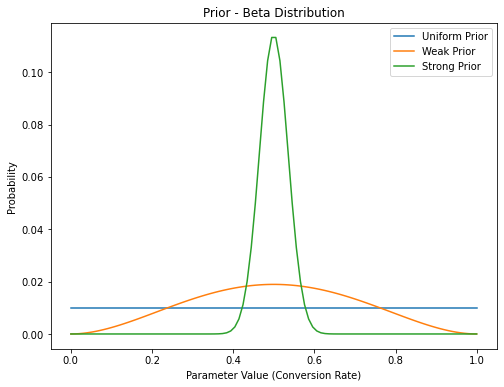

In [34]:
# Define line space
x = np.linspace(0, 1, num=100)


# Define Beta Distributions
alpha, beta = 1,1 # Uninformative Prior
beta_1 = stats.beta.pdf(x, a=alpha, b=beta)/sum(stats.beta.pdf(x, a=alpha, b=beta))

alpha, beta = 3,3 # Weak Prior
beta_2 = stats.beta.pdf(x, a=alpha, b=beta)/sum(stats.beta.pdf(x, a=alpha, b=beta))

alpha, beta = 101,101 # Strong Prior
beta_3 = stats.beta.pdf(x, a=alpha, b=beta)/sum(stats.beta.pdf(x, a=alpha, b=beta)) 


# Plot
plt.figure(figsize = (8, 6))
plt.plot(x, beta_1)
plt.plot(x, beta_2)
plt.plot(x, beta_3)
plt.xlabel('Parameter Value (Conversion Rate)')
plt.ylabel('Probability')
plt.title('Prior - Beta Distribution')
plt.legend(['Uniform Prior', 'Weak Prior', 'Strong Prior'])
plt.show()

## Posterior Distribution
Again, we are most interested in finding the posterior distribution of our parameter(s). Given our likelihood function (Binomial Distribution) and prior distribution (Beta Distribution) we are presented with a special case in which we can apply __conjugate priors__ to obtain a closed form solution for the posterior distribution. In this case the posterior distribution is of the same form as the prior.

Referencing the closed form solution (https://en.wikipedia.org/wiki/Conjugate_prior):

$$
P(\theta|X) = Beta(X|\alpha', \beta')
$$
where $\alpha'$ and $\beta'$ include information from the prior and experiment:

$$
\alpha' = \alpha + S
$$$$
\beta' = \beta + F
$$

We will use this posterior distribution form in analyzing the results of the A/B test.

# Collect Data

For comparison's sake, we will analyze the same data obtained in the Frequentist example. In particular, we will use the same number of observations and the same 50/50 split between A and B. We will also use an uninformative prior.

In [35]:
# Number observations from both A and B
n_obs = int(n_req/2) #integer value

# Half observations from A
data_A = X1[range(n_obs)]
print("Number of A samples collected: %1d" % data_A.shape)

# Half observations from B
data_B = X2[range(n_obs)]
print("Number of B samples collected: %1d" % data_B.shape)

print("\n")
print("Data A:")
print("Samples Collected: %1d" %data_A.shape)
print("Number of Conversions: %1d" % data_A.sum())
print("Conversion Rate: %2f" %data_A.mean())
print("Variance: %2f" %data_A.var())

print("\nData B:")
print("Samples Collected: %1d" %data_B.shape)
print("Number of Conversions: %1d" % data_B.sum())
print("Conversion Rate: %2f" %data_B.mean())
print("Variance: %2f" %data_B.var())

Number of A samples collected: 9600
Number of B samples collected: 9600


Data A:
Samples Collected: 9600
Number of Conversions: 2319
Conversion Rate: 0.241563
Variance: 0.183210

Data B:
Samples Collected: 9600
Number of Conversions: 2933
Conversion Rate: 0.305521
Variance: 0.212178


## Calculate Posterior Distributions

Calculate the posterior distributions of the conversion rate.

In [36]:
# Define linespace
line_parts = 1000
x = np.linspace(0, 1, num=line_parts)

In [37]:
# Data A

# Define alpha', beta' - Successes, Failures, Uninformative Prior
S = sum(data_A)
F = data_A.shape[0] - S
alpha_A = 1 + S
beta_A = 1 + F

# Calculate Posterior Distribution
posterior_A = stats.beta.pdf(x, a=alpha_A, b=beta_A)/sum(stats.beta.pdf(x, a=alpha_A, b=beta_A))

In [38]:
# Data B

# Define alpha', beta' - Successes, Failures, Uninformative Prior
S = sum(data_B)
F = data_B.shape[0] - S
alpha_B = 1 + S
beta_B = 1 + F

# Calculate Posterior Distribution
posterior_B = stats.beta.pdf(x, a=alpha_B, b=beta_B)/sum(stats.beta.pdf(x, a=alpha_B, b=beta_B))

## Analyze Results

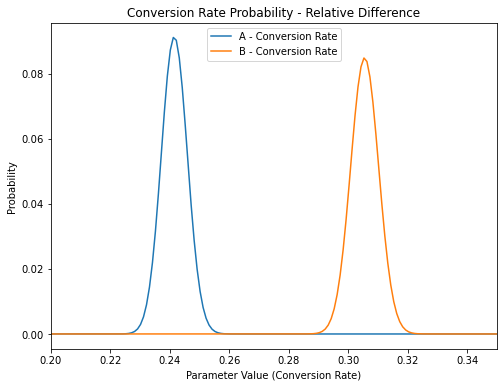

In [39]:
# Plot
plt.figure(figsize = (8, 6))
plt.plot(x, posterior_A)
plt.plot(x, posterior_B)
plt.xlim(mean_A-.05, mean_B+.05)
plt.xlabel('Parameter Value (Conversion Rate)')
plt.ylabel('Probability')
plt.yticks(ticks=None, labels=None)
plt.title('Conversion Rate Probability - Relative Difference')
plt.legend(['A - Conversion Rate', 'B - Conversion Rate'])
plt.show()

While the preceding plot of the posterior probabilities is fairly straightforward to interpret in this case, it is still useful to develop a more analytical framework from which to compare the two distributions.

In the context of this problem, we are specifically seeking the probability that the conversion rate of B is greater than A. Given (i) that we know the posterior distributions are Beta functions and (ii) in order to find the probability that $P(\theta_A) > P(\theta_B)$ we must integrate over the joint distribution it can be shown that:

$$
Pr(p_B > p_A) = \sum_{i=0}^{\alpha_B-1} \frac{Beta(\alpha_A+i, \beta_B + \beta_A)}{(\beta_B+i)Beta(1+i, \beta_B)Beta(\alpha_A, \beta_B)}
$$


(Useful resource for full derivation: https://www.evanmiller.org/bayesian-ab-testing.html)

In terms of implementation, the Beta function can produce large values and hence, it is typically implemented using log values.

In [40]:
def prob_B_better (alpha_A, beta_A, alpha_B, beta_B):
    total = 0
    for i in range(0, alpha_B): # Note add one to alpha_B - 1 for full range
        total += math.exp(
            betaln(alpha_A+i, beta_B+beta_A) -\
            math.log(beta_B + i) -\
            betaln(1+i, beta_B) -\
            betaln(alpha_A, beta_A)
        )
    return total

In [41]:
prob = prob_B_better (alpha_A, beta_A, alpha_B, beta_B)
print("Probability B is better than A: {:.2f}".format(prob*100))

Probability B is better than A: 100.00


## Additional Observations

We will again make some observations regarding the experimental results and design.

- __Lift:__ This can be calculated using Thompson sampling (not performed in this particular notebook) and results in a probability distribution that the parameter for B is greater than that of A.
- __Sample Size__ The sample size necessary to perform an effective A/B is signficantly lower when implementing the Bayesian approach relative to the Frequentist approach. A rule of thumb is approximately half of the number of observations are needed, though this is subsequently explored in greater detail.
- __Interpretation:__ "There is an X% chance that B is better than A and the expected lift is Y percentage points." - This is easy for a non-technical audience to interpret.
- __Optimization During Experiment:__ Optimization of our desired metric (e.g. clicks, conversion, purchases) can be done during the data collection phase of the experiment (see Multi-Armed Bandit for additional detail). This reduces opportunity cost in the real world. 

In [42]:
#Frequentist Approach

# Lift = (CR_B - CR_A ) / CR_A
cr_A = posterior_A.argmax()/line_parts
cr_B = posterior_B.argmax()/line_parts
lift = (cr_B - cr_A) / cr_A

print("Most probable Conversion Rate (A): {:.3f}".format(cr_A))
print("Most probable Conversion Rate (B): {:.3f}".format(cr_B))
print("Conversion Rate Lift of B over A: {:.3f}".format(lift))

Most probable Conversion Rate (A): 0.241
Most probable Conversion Rate (B): 0.305
Conversion Rate Lift of B over A: 0.266


# Testing

We can simulate testing of our experiment by generating data and performing the analysis multiple times. A/A testing is simulated below, with the expectation that the Frequentist Approach will result in a false positive rate 5% of the time. Similarly, we can simulate the A/B test where we would expect a false negative rate approximately 20% of the time. It should be noted that the number of required observations was calculated previuosly using a "rule of thumb", which makes this analysis more useful and important. An arbitary value of 95% probability was chosen as the cutoff for a correct Bayesian prediction.

* Expect 5% false positive rate
* Expect 20% false negative rate

### Define Functions

In [43]:
# Generate Data
def gen_binomial_data(mean_A, mean_B, sample_size):
    sample = int(math.ceil(sample_size/2))  #sample size for each individual dataset
    X1=np.random.binomial(n=1, p=mean_A, size=sample)
    X2=np.random.binomial(n=1, p=mean_B, size=sample)
    return X1, X2

# Perform Frequentist Analysis
def frequ_analysis(data_A, data_B):
    p_val = stats.ttest_rel(data_A, data_B).pvalue
    test_stat = stats.ttest_rel(data_A, data_B).statistic
    return p_val, test_stat

# Perform Bayesian Analysis
def prob_B_better (alpha_A, beta_A, alpha_B, beta_B):
    total = 0
    for i in range(0, alpha_B): # Note add one to alpha_B - 1 for full range
        total += math.exp(
            betaln(alpha_A+i, beta_B+beta_A) -\
            math.log(beta_B + i) -\
            betaln(1+i, beta_B) -\
            betaln(alpha_A, beta_A)
        )
    return total

def calc_posterior_params(data):
    alpha = 1 + sum(data) # 1 + Successes
    beta = 1 + data_A.shape[0] - sum(data) # 1 + Failures
    return alpha, beta
    
def bayes_analysis(data_A, data_B):
    alpha_A, beta_A = calc_posterior_params(data_A)
    alpha_B, beta_B = calc_posterior_params(data_B)
    prob = prob_B_better(alpha_A, beta_A, alpha_B, beta_B)
    return prob

### Perform A/A Tests

In [44]:
sig_level = 0.05
results = []
n = n_req

for i in range(1000):
    # Generate Data
    data_A, data_B = gen_binomial_data(mean_A = 0.25, mean_B = 0.25, sample_size = n)

    # Frequentist Analysis
    p_val, test_stat = frequ_analysis(data_A, data_B)
    if p_val < sig_level:
        freq_correct = 1
    else:
        freq_correct = 0

    # Bayes Analysis
    bayes_prob_B = bayes_analysis(data_A, data_B)
    if bayes_prob_B > 0.95:
        bayes_correct = 1
    else:
        bayes_correct = 0

    results.append([p_val, bayes_prob_B, freq_correct, bayes_correct])

df_AA = pd.DataFrame(results, columns = ['p_value', 'prob_B_better', 'freq_FP', 'bayes_FP'])
print("False Positives - Frequentist: {:.3f}".format(df_AA['freq_FP'].sum()/df_AA.shape[0]))
print("False Positives - Bayesian: {:.3f}".format(df_AA['bayes_FP'].sum()/df_AA.shape[0]))

False Positives - Frequentist: 0.056
False Positives - Bayesian: 0.053


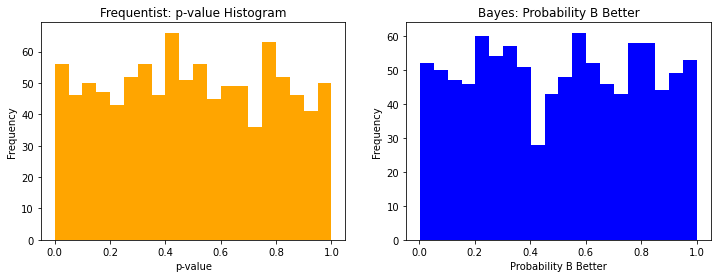

In [72]:
fig = plt.figure(figsize=(12,4))

ax1 = fig.add_subplot(121)
ax1.hist(x=df_AA['p_value'], bins=20, color='orange')
plt.xlabel('p-value')
plt.ylabel('Frequency')
plt.title('Frequentist: p-value Histogram')

ax2 = fig.add_subplot(122)
ax2.hist(x=df_AA['prob_B_better'], bins=20, color='b')
plt.xlabel('Probability B Better')
plt.ylabel('Frequency')
plt.title('Bayes: Probability B Better')

plt.show()

### Perform A/B Tests

In [65]:
sig_level = 0.05
results = []
n = n_req

for i in range(1000):
    # Generate Data
    data_A, data_B = gen_binomial_data(mean_A = 0.25, mean_B = 0.265, sample_size = n)

    # Frequentist Analysis
    p_val, test_stat = frequ_analysis(data_A, data_B)
    if p_val < sig_level:
        freq_correct = 1
    else:
        freq_correct = 0

    # Bayes Analysis
    bayes_prob_B = bayes_analysis(data_A, data_B)
    if bayes_prob_B > 0.95:
        bayes_correct = 1
    else:
        bayes_correct = 0

    results.append([p_val, bayes_prob_B, freq_correct, bayes_correct])
    

df_AB = pd.DataFrame(results, columns = ['p_value', 'prob_B_better', 'freq_correct', 'bayes_correct'])
print("True Positives - Frequentist: {:.3f}".format(df_AB['freq_correct'].sum()/df_AA.shape[0]))
print("True Positives - Bayesian: {:.3f}".format(df_AB['bayes_correct'].sum()/df_AA.shape[0]))

True Positives - Frequentist: 0.660
True Positives - Bayesian: 0.760


In [66]:
df_results = pd.DataFrame(results, columns = ['p_value', 'prob_B_better', 'freq_correct', 'bayes_correct'])

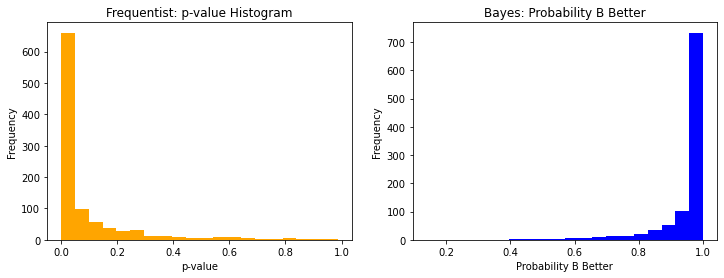

In [73]:
fig = plt.figure(figsize=(12,4))

ax1 = fig.add_subplot(121)
ax1.hist(x=df_AB['p_value'], bins=20, color='orange')
plt.xlabel('p-value')
plt.ylabel('Frequency')
plt.title('Frequentist: p-value Histogram')

ax2 = fig.add_subplot(122)
ax2.hist(x=df_AB['prob_B_better'], bins=20, color='b')
plt.xlabel('Probability B Better')
plt.ylabel('Frequency')
plt.title('Bayes: Probability B Better')

plt.show()

# Conclusion

While fewer people are often initially comfortable with Bayesian principles, a Bayesian approach to A/B testing provides a more straightforward analysis, improved performance, and a more intuitive description of the results. 

* __Analysis:__
    * __Frequentist Approach__ - (i) Figure out what we want to explore, (ii) assume the opposite is true, (iii) try to disprove it by showing that the observed data is improbable if the null is assumed to be true
    * __Bayesian Approach__ - (i) Compute the probability distributions for associated with the desired metric for A & B, (ii) calculate the probability that the metric is bigger for B than A

* __Performance:__ The Bayesian approach requires fewer observations to reach the same decision boundary. Conversely, if applied to the same dataset, the Bayesian approach has fewer Type II errors (failing to reject the null).

* __Description of Results:__
    * __Frequentist Approach__ - "If we assume the null hypothesis is true we would only observe data as extreme or more so than what we saw {p-value}% of the time, so we reject the null hypothesis and conclude the alternative"
    * __Bayesian Approach__ - "There is an X% chance that B is better than A and the expected lift is Y percentage points". Additionally, a simple histogram of the parameter probability distributions is incredibly interpreted to even laimen individuals.

## Topics for Additional Research & Discussion

* Sequential Experimental Design

* Multivariate Testing

* Solving Bayes using Thompson Sampling (specifically in calculating lift)

* Multi-Armed Bandit

## Really Useful Resourcces

#### A/B Testing All Around Resource
"Trustworthy Online Controlled Experiments: A Practical Guide to A/B Testing" Ron Kohavi, Diane Tang, Ya Xu

#### A/B Testing Mathematical Framework
"How Not to Run an A/B Test" Evan Miller
https://www.evanmiller.org/how-not-to-run-an-ab-test.html

A/B Testing Without Losing Your Job, Ben Tilly:
https://elem.com/~btilly/ab-testing-multiple-looks/part1-rigorous.html

#### Bayesian A/B Testing

"Bayesian A/B Testing" Evan Miller
https://www.evanmiller.org/bayesian-ab-testing.html

"Bayesian A/B Testing at VWO" - Chris Stucchio
https://www.chrisstucchio.com/pubs/slides/gilt_bayesian_ab_2015/slides.html#1

"Nora Neumann - Usable A/B testing - A Bayesian approach." PyData June 1, 2016 
https://youtu.be/PSqtcNZDj4A

#### Conjugate Priors
Conjugate Priors
https://en.wikipedia.org/wiki/Conjugate_prior

#### Statistical Test Flow Charts

LaNts and Laminins
https://lantsandlaminins.com/statistics-test-flow-chart/
